In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import plotly.express as px 
import plotly.graph_objs as go
import glob,os

In [7]:
stockDF = pd.DataFrame()
today = date.today().strftime("%Y-%m-%d")
#print(today)
past = (datetime.now() - relativedelta(years=2)).strftime("%Y-%m-%d")
#print(past)

# Most Popular Stocks

In [8]:
import requests,time
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
from datetime import datetime,timedelta,date
from dateutil.relativedelta import relativedelta
import lxml

html = requests.get('https://companiesmarketcap.com/').content
tableList = pd.read_html(html)
comList= tableList[0]
comList = comList.set_index('Name')
comList = comList.index.tolist()

#collect the symbos for the 100 popular company stocks
comDic = {}  #comDic = {symbol: company name}
for i in range(len(comList)):
    if len(comList[i].split())==2:
        comDic[comList[i].split()[-1]]=comList[i].split()[0]
    else:
        name = ' '.join(comList[i].split()[:-1])
        comDic[comList[i].split()[-1]]=name
    
symbols = list(comDic.keys())
symbols = [x for x in symbols if not any(c.isdigit() for c in x)]
#print(len(symbols))

# Get Past 2 Years Data For 50 Stocks From Alpha Vantage

In [9]:
def get_multiple_data(symbols,start,end):
    #stockDF = pd.DataFrame()
    ts = TimeSeries(key='L6DM6V2VXBTDAMX9',output_format='pandas')
    i = 0
    
    if not os.path.exists('test'):
        os.mkdir('test')
    
    if not os.path.exists('train'):
        os.mkdir('train')
        
    while i < 50:
    #while i < len(symbols):
        print(i)
        try:
            data = ts.get_daily_adjusted(symbol=symbols[i],outputsize='full')
            data = pd.DataFrame(list(data)[0])
            intervalData = data.loc[start:end]
            stockSymbol = [i]*len(intervalData.index)
            intervalData = intervalData.copy()
            intervalData.loc[:,'stock symbol'] = [symbols[i]]*len(intervalData.index)
            
            intervalData['change'] = intervalData['4. close'] - intervalData['4. close'].shift(-1)
            intervalData['pct_change (%)'] = round((intervalData['4. close'] - intervalData['4. close'].shift(-1))*100/intervalData['4. close'].shift(-1),3)

            #Moving Average
            intervalData['MA5_close'] = intervalData['4. close'].rolling(5).mean()
            intervalData['MA5_open'] = intervalData['1. open'].rolling(5).mean()

            intervalData['MA30_close'] = intervalData['4. close'].rolling(30).mean()
            intervalData['MA30_open'] = intervalData['1. open'].rolling(30).mean()


            intervalData = intervalData.dropna()
            
            test_data = intervalData.head(100)
            train_data = intervalData[100:]
            
            train_data.to_csv(os.getcwd()+'/train/'+symbols[i]+'.csv')
            test_data.to_csv(os.getcwd()+'/test/'+symbols[i]+'_test.csv')

            i += 1
        except Exception as e:
            print('except: '+symbols[i])
            print('error: '+str(e))
            time.sleep(60)

In [10]:
get_multiple_data(symbols,today,past)
print('successfully')

0
1
2
3
4
5
6
7
8
9
except: TSM
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
9
10
11
12
13
14
except: NVDA
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
14
15
16
17
18
19
20
21
22
23
24
except: RHHBY
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would like to target a higher API call frequency.
24
25
26
27
28
29
except: NFLX
error: Thank you for using Alpha Vantage! Our standard API call frequency is 5 calls per minute and 500 calls per day. Please visit https://www.alphavantage.co/premium/ if you would 

# 用可视化对所选的50支股票进行市场结构聚类分析

股票市场波动往往存在一定的共振，尤其是同一个行业或者是概念的公司股票，当面临行业冲击时，其波动性存在一定的相似性，即表现出同涨或者同跌。如果能通过交易行情数据对股票市场的波动结构进行分析，对我们预测股票局势有重要的启示作用。

In [25]:
def stock_filter():
    stocks = pd.DataFrame()
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"):        
        stock = pd.read_csv(file)
        stock.drop(columns=['7. dividend amount','8. split coefficient'],inplace = True)
        #res = stock[stock['date'] > '2015-12-31']
        if  'AAPL' in file:
            pass
        else:
            stocks = pd.concat([stocks,stock])
    return stocks

In [26]:
stock_filter = stock_filter()

In [27]:
from sklearn import cluster, covariance, manifold
from matplotlib.collections import LineCollection

def manifoldAnalysis(df,comDic):    
    new_df = df[['date', 'stock symbol', 'change']].copy()
    new_df = new_df.pivot(index='date',columns='stock symbol')
    
    newDic ={}
    columns_values = list(new_df.columns.values)
    col_names = [x[1] for x in columns_values]

    for i in range(len(col_names)):
        if col_names[i] in comDic:
            newDic[col_names[i]] = comDic[col_names[i]]
    
    symbols, names = np.array(sorted(newDic.items())).T

    variation = new_df.dropna().values
    
    edge_model = covariance.GraphicalLassoCV()
    X = variation.copy()
    X /= X.std(axis=0)
    edge_model.fit(X)
    _, labels = cluster.affinity_propagation(edge_model.covariance_,random_state=0)
    n_labels = labels.max()
    
    stock_cluster=[]
    
    for i in range(n_labels + 1):
        print('Cluster '+str(i+1)+':'+', '.join(names[labels==i]))
        stock_cluster.append([symbols[labels==i],names[labels==i]])
        
    #Visualization
    node_position_model = manifold.LocallyLinearEmbedding(eigen_solver='dense', n_neighbors=5)
    embedding = node_position_model.fit_transform(X.T).T

    plt.figure(1, facecolor='w', figsize=(22, 18))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')
    
    partial_correlations = edge_model.precision_.copy()
    d = 1 / np.sqrt(np.diag(partial_correlations))
    partial_correlations *= d
    partial_correlations *= d[:, np.newaxis]
    non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.05)
       
    plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,cmap=plt.cm.nipy_spectral)

    start_idx, end_idx = np.where(non_zero)

    segments = [[embedding[:, start], embedding[:, stop]]for start, stop in zip(start_idx, end_idx)]
    values = np.abs(partial_correlations[non_zero])
    lc = LineCollection(segments,zorder=0, cmap=plt.cm.hot_r,norm=plt.Normalize(0, .7 * values.max()))
    lc.set_array(values)
    lc.set_linewidths(15 * values)
    ax.add_collection(lc)

    for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
        dx = x - embedding[0]
        dx[index] = 1
        dy = y - embedding[1]
        dy[index] = 1
        this_dx = dx[np.argmin(np.abs(dy))]
        this_dy = dy[np.argmin(np.abs(dx))]
        if this_dx > 0:
            horizontalalignment = 'left'
            x = x + .003
        else:
            horizontalalignment = 'right'
            x = x - .003
        if this_dy > 0:
            verticalalignment = 'bottom'
            y = y + .003
        else:
            verticalalignment = 'top'
            y = y - .003
        plt.text(x, y, name, size=10,horizontalalignment=horizontalalignment,verticalalignment=verticalalignment,
                 bbox=dict(facecolor='w',edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),alpha=.6))

    plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
             embedding[0].max() + .10 * embedding[0].ptp(),)
    plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
             embedding[1].max() + .03 * embedding[1].ptp())
    
    plt.show()
    return stock_cluster

c:\python38\lib\site-packages\sklearn\covariance\_graph_lasso.py:240: RuntimeWarning:

invalid value encountered in multiply

c:\python38\lib\site-packages\sklearn\covariance\_graph_lasso.py:242: RuntimeWarning:

invalid value encountered in multiply



Cluster 1:Bank of America, Berkshire Hathaway, Comcast, Chevron, JPMorgan Chase, AT&T, Exxon Mobil
Cluster 2:China Construction Bank, Ping An Insurance
Cluster 3:Meituan
Cluster 4:AbbVie, Abbott Laboratories, Adobe, Amazon, ASML, Salesforce, Facebook, Alphabet (Google), Intel, Microsoft, Netflix, NVIDIA, Oracle, PayPal, TSMC
Cluster 5:L'Oréal
Cluster 6:Johnson & Johnson, Coca-Cola, Nestlé, Novartis, Pepsico, Pfizer, Procter & Gamble, Roche, Verizon, Walmart
Cluster 7:Alibaba, Tencent
Cluster 8:Tesla
Cluster 9:Cisco, Walt Disney, Home Depot, LVMH, Mastercard, Merck, Nike, Toyota, UnitedHealth, Visa


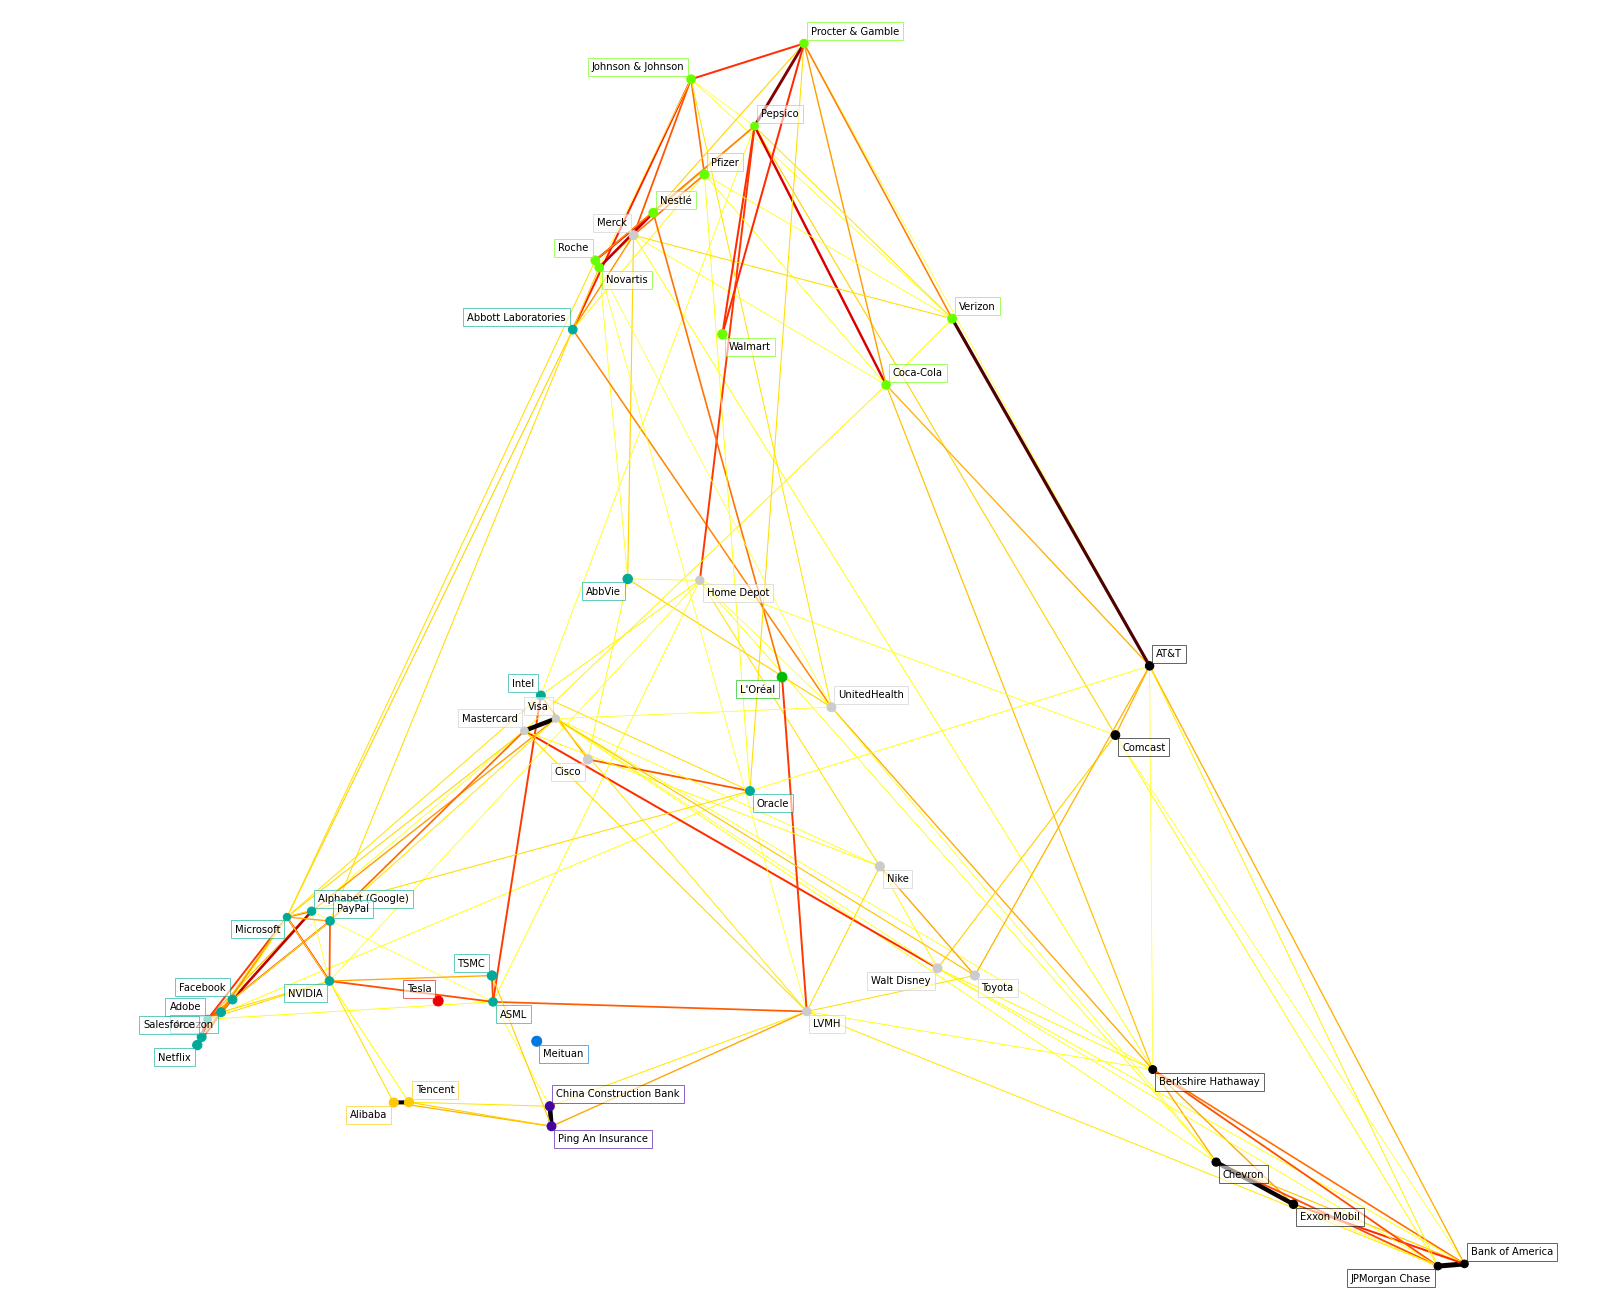

In [28]:
stock_cluster = manifoldAnalysis(stock_filter,comDic)

图表反应了变量之间的条件关系，而聚类反映了边际所属性：聚在一起的变量可以被认为在整个股票市场水平上具有类似的影响。
从图中可以看出，无监督学习通过对每日增幅信息的提取，可以大致勾勒出50支股票的一个市场结构，具有相同行业属性或概念属性的个股其波动表现出相似性，如科技，银行等。

###  2年来Max Return （%） for each stock

In [69]:
def stockExplore():
    stocks = pd.DataFrame()
    #os.chdir(directory)
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"):        
        stock = pd.read_csv(file)
        stock.drop(columns=['6. volume','7. dividend amount','8. split coefficient'],inplace = True)
        stocks = pd.concat([stocks,stock])
    return stocks

In [70]:
stocks = stockExplore()
stocks

,date,1. open,2. high,3. low,4. close,5. adjusted close,stock symbol,change,pct_change (%),MA5_close,MA5_open,MA30_close,MA30_open
0,2020-10-12,120.06,125.18,119.2845,124.40,123.999636,AAPL,7.43,6.352,121.284,121.266,117.014333,117.192333
1,2020-10-09,115.28,117.00,114.9200,116.97,116.593548,AAPL,2.00,1.740,120.874,120.066,117.002000,117.080333
2,2020-10-08,116.25,116.40,114.5901,114.97,114.599985,AAPL,-0.11,-0.096,119.726,119.572,116.879667,117.035667
3,2020-10-07,114.62,115.55,114.1300,115.08,114.709631,AAPL,1.92,1.697,118.504,118.296,116.781333,116.902667
4,2020-10-06,115.70,116.12,112.2500,113.16,112.795810,AAPL,-3.34,-2.867,116.916,116.382,116.573667,116.774333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,2019-04-29,80.12,80.38,79.6600,79.97,70.237169,XOM,-0.52,-0.646,78.736,79.300,75.440667,75.519000
369,2019-04-26,80.27,80.63,79.5600,80.49,70.693882,XOM,-1.73,-2.104,79.340,79.796,75.626667,75.688333
370,2019-04-25,81.65,82.84,81.4000,82.22,72.213330,XOM,0.46,0.563,80.326,80.470,75.881333,75.926333
371,2019-04-24,83.01,83.08,81.7300,81.76,71.809315,XOM,-1.62,-1.943,80.944,81.084,76.129667,76.236333


In [33]:
def performance(df):
    new_df = df[['date', 'stock symbol', '4. close']].copy()
    new_df['date'] = pd.to_datetime(new_df['date'])
    new_df = new_df.pivot(index='date',columns='stock symbol')
    #print(new_df.head(2))
    
    cum_ret = new_df.groupby(pd.Grouper(freq="Y")).apply(lambda x:(((x/x.shift(1)-1).fillna(0)+1.0).cumprod().round(3)))
    total_ret = (cum_ret.iloc[-1]-1).sort_values(ascending=False)
    annual_ret = total_ret.apply(lambda x:pow(1+x,1/15)-1)
    dd = (cum_ret.cummax()-cum_ret)/cum_ret.cummax()
    d = dd.max()
    ex_return = new_df.apply(lambda x:(x/x.shift(1)-1).fillna(0)-0.03/250)
    sharper_ratio = np.sqrt(len(ex_return))*ex_return.mean()/ex_return.std()
    perf_df = pd.DataFrame()
    
    perf_df['max return (%)']=round(d*100,3)
    perf_df['annual return (%)'] = round(annual_ret*100,3)
    perf_df['total return']= round(total_ret,3)
    perf_df['sharper ratio'] = round(sharper_ratio,3)
    #print(perf_df)
        
    index = perf_df.index.tolist()
 
    symbol_names = [x[1] for x in index]
    newDic = {}
    for i in range(len(symbol_names)):
        if symbol_names[i] in comDic:
            newDic[(index[i],symbol_names[i])] = comDic[symbol_names[i]]
    
    perf_df['company'] = [y for y in newDic.values()]
    
    perf_df.set_index('company',inplace=True)
    
    perf_df = perf_df.sort_values('max return (%)',ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=perf_df.index,y=perf_df['max return (%)'],marker=dict(color='#A2D5F2')))
    fig.update_layout(title=go.layout.Title(text='Max Return % Over the Past 2 Years', font=dict(family="Courier New, monospace",size=22,color="#000000")))
    fig.show()
    
    return perf_df

In [71]:
perf_df = performance(stocks)
perf_df

,max return (%),annual return (%),total return,sharper ratio
company,,,,
Tesla,81.820,-0.033,-0.005,1.331
Apple,77.345,-5.226,-0.553,0.302
Meituan,58.921,6.336,1.513,1.468
Bank of America,56.705,-2.257,-0.290,-0.054
Chevron,56.208,-3.074,-0.374,-0.547
ASML,54.980,2.200,0.386,1.621
Exxon Mobil,54.400,-4.567,-0.504,-1.510
JPMorgan Chase,54.123,-2.340,-0.299,-0.053
UnitedHealth,50.716,0.576,0.090,0.875


### Comment

从图表中可以看出来，在过去的两年里，在max return 排名前十的股票中，其中属于cluster 2 的股票占比例最多

改一下##########################################

查看年化收益率排名前十的个股情况，Chevron Corporation十年来累计收益率为0.317%，年化收益1.853%，最大回撤63.3%，夏普比率为0.346，作为“买入持有策略”当之无愧的王者，当然排在第二的intel似乎知名度更高。其他上榜的个股年化超过25%，夏普比率大于2.5，但最大回撤均接近或超过60%，金证股份更高达90%。

所以我们对cluster 4 的几支股票进行分析

In [72]:
stock_cluster4 = stock_cluster[3]
stock_cluster4_names = stock_cluster4[1]
stock_cluster4_symbols = stock_cluster4[0]

In [73]:
stock_cluster4_names

array(['AbbVie', 'Abbott Laboratories', 'Adobe', 'Amazon', 'ASML',
       'Salesforce', 'Facebook', 'Alphabet (Google)', 'Intel',
       'Microsoft', 'Netflix', 'NVIDIA', 'Oracle', 'PayPal', 'TSMC'],
      dtype='<U23')

In [74]:
stock_cluster4_symbols

array(['ABBV', 'ABT', 'ADBE', 'AMZN', 'ASML', 'CRM', 'FB', 'GOOG', 'INTC',
       'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL', 'TSM'], dtype='<U23')

## 2年来市场整体的涨跌收益情况分析

In [75]:
def plot_data(df,condition,title):
    newDF = df[condition]
    newDF.index = pd.to_datetime(newDF['date'])
    count = newDF.groupby(by=newDF.index.month)['stock symbol'].nunique()
    countGP = newDF.groupby(by=newDF.index.month)['stock symbol'].unique()
    
    new_list=[]
    
    for row in countGP:
        row_list = row.tolist()
        for i in range(len(row_list)):
            if row_list[i] in comDic:
                row_list[i] = comDic[row_list[i]]
        new_list.append(row_list)  
    
    count_df = pd.DataFrame({'month':count.index, 'count_stock':count.values,'companies':new_list})

    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=count_df.month,y=count_df.count_stock,marker=dict(color='#A2D5F2')))

    fig.update_layout(title=title,xaxis_title="month",yaxis_title="count",
                      font=dict(family="Courier New, monospace",size=22,color="#000000"))
    fig.show()
    return count_df

In [76]:
pct_change_10_p = plot_data(stocks,stocks['pct_change (%)']>10,'2年以来股价涨幅超过10%个股时间分布')
pct_change_10_p

,month,count_stock,companies
0,1,1,[Tesla]
1,2,1,[Tesla]
2,3,30,"[Apple, Abbott Laboratories, Adobe, ASML, Bank..."
3,4,8,"[ASML, Chevron, Mastercard, NVIDIA, PayPal, Te..."
4,5,2,"[Meituan, PayPal]"
5,7,4,"[Apple, Alphabet (Google), Tesla, TSMC]"
6,8,3,"[Salesforce, Netflix, Tesla]"
7,9,1,[Tesla]
8,10,1,[Tesla]


In [85]:
pct_change_10_n = plot_data(stocks,stocks['pct_change (%)']<-10,'2年以来股价日跌幅超过-10%个股时间分布')
pct_change_10_n

,month,count_stock,companies
0,2,1,[Tesla]
1,3,29,"[Apple, AbbVie, Adobe, ASML, Bank of America, ..."
2,5,2,"[Meituan, Tesla]"
3,6,2,"[AbbVie, Bank of America]"
4,7,3,"[Intel, Netflix, Tesla]"
5,8,3,"[Apple, Cisco, Tesla]"
6,9,1,[Tesla]


从涨幅和跌幅可以看出来，cluster 4的股票涨幅情况较好。

这两年来，每年的3月是股票的涨跌幅高峰期。



###  2年来cumulative return排名最前的10支股票

In [87]:
def top10_cum_return(df):
    new_df = df[['date', 'stock symbol', '4. close']].copy()
    new_df = new_df.pivot(index='date',columns='stock symbol')
    new_df.dropna(inplace=True)
    
    ##########################
    #top10 = ((new_df.iloc[-1]/new_df.iloc[0]-1).dropna().sort_values(ascending=False)[:10])
    top10 = ((new_df.iloc[-1] - new_df.iloc[0]) / new_df.iloc[0]).dropna().sort_values(ascending=False)[:10]

    index = top10.index.tolist()

    newDic = {}
    index_names = [x[1] for x in index]

    for i in range(len(index_names)):
        if index_names[i] in comDic:
            newDic[index_names[i]] = comDic[index_names[i]]
        
    top10 = pd.DataFrame({'stock symbol':[key for key in newDic.keys()],'company':[x for x in newDic.values()],'cumulative_return':top10.values})
    
    fig = go.Figure()
    fig.add_trace(go.Bar(x=top10.company,y=top10.cumulative_return,marker=dict(color='#A2D5F2')))
    fig.update_layout(title=go.layout.Title(text="2年来收益率排名最前的10支股票", font=dict(family="Courier New, monospace",size=22,color="#000000")))
    fig.show() 
    
    return top10

In [88]:
top10 = top10_cum_return(stocks)
top10

,stock symbol,company,cumulative_return
0,MPNGF,Meituan,4.018182
1,NVDA,NVIDIA,1.976618
2,TSM,TSMC,1.001982
3,ASML,ASML,0.942651
4,PYPL,PayPal,0.879407
5,ADBE,Adobe,0.854747
6,AMZN,Amazon,0.810401
7,MSFT,Microsoft,0.771058
8,TSLA,Tesla,0.709967
9,CRM,Salesforce,0.673790


收益率排名前十的股票中，有40%都属于cluster 4 ，科技股

那我们看一下cluster 2 中 股票的 k line plot趋势

### cluster 2 中 股票的 k line plot

In [89]:
import matplotlib
from mplfinance.original_flavor import candlestick2_ohlc
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates

def draw_kline(stock_symbol,title):
    
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"): 
        if stock_symbol in file:
            df = pd.read_csv(file)
            break   
    
    #df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.sort_values(by=['date'],inplace=True)
    #df.set_index('date',inplace=True)
    
    matplotlib.style.use('ggplot')
    
    fig, ax = plt.subplots(1, 1, figsize=(8,3), dpi=200)
    candlestick2_ohlc(ax,opens = df['1. open'].values,highs = df['2. high'].values,
                lows = df[ '3. low'].values,
                closes = df['4. close'].values,
                  width=0.5, colorup="r",colordown="g")
    
    ax.set_facecolor("white")
    ax.set_title(title)
    
    ########################################################################################################
    plt.plot(df['MA5_close'].values, alpha = 0.5, label='MA5_close')
    plt.plot(df['MA30_close'].values, alpha = 0.5, label='MA30_close')
    ########################################################################################################
    #plt.plot(df['MA10_close'].values, alpha = 0.5, label='MA10_close')
    #plt.plot(df['MA20_close'].values, alpha = 0.5, label='MA20_close')
    
    ax.legend(facecolor='white', edgecolor='black', fontsize=6)

    plt.xticks(ticks =np.arange(0,len(df)), labels = df.date)
    plt.xticks(size=8)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    plt.show()

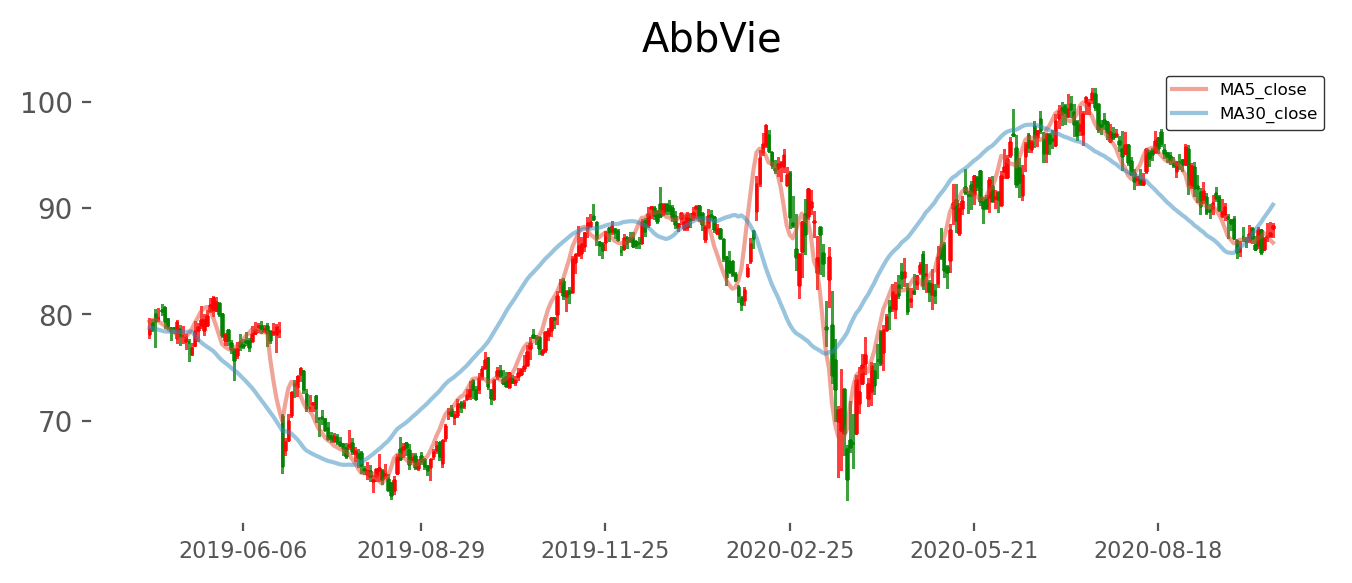

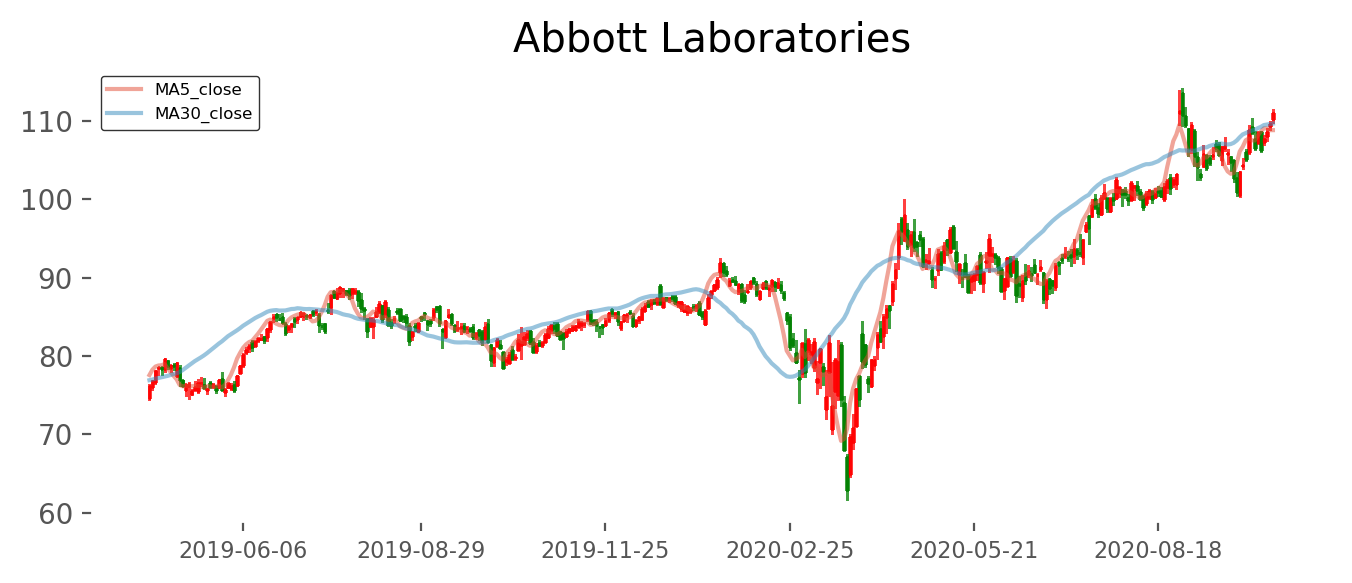

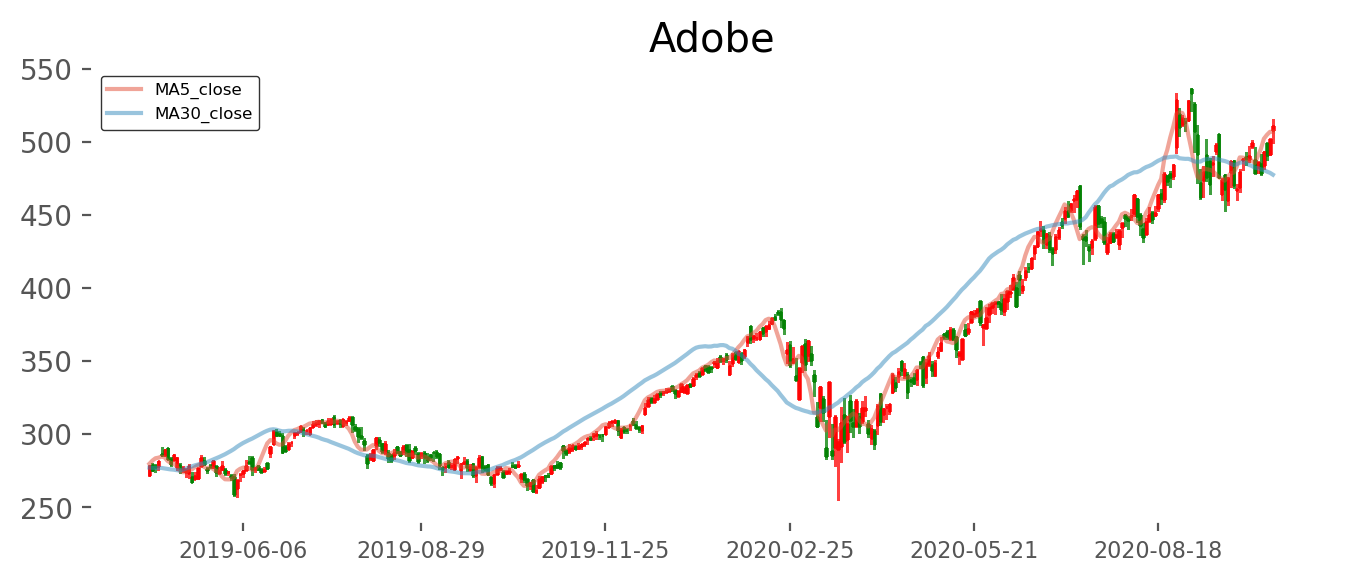

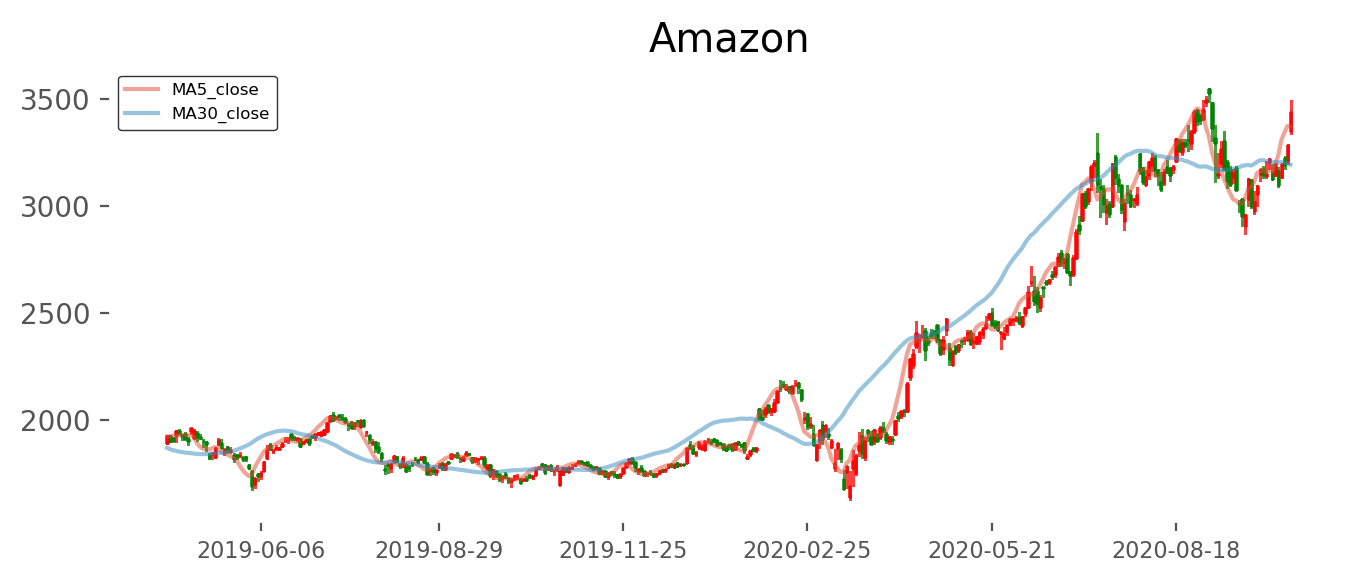

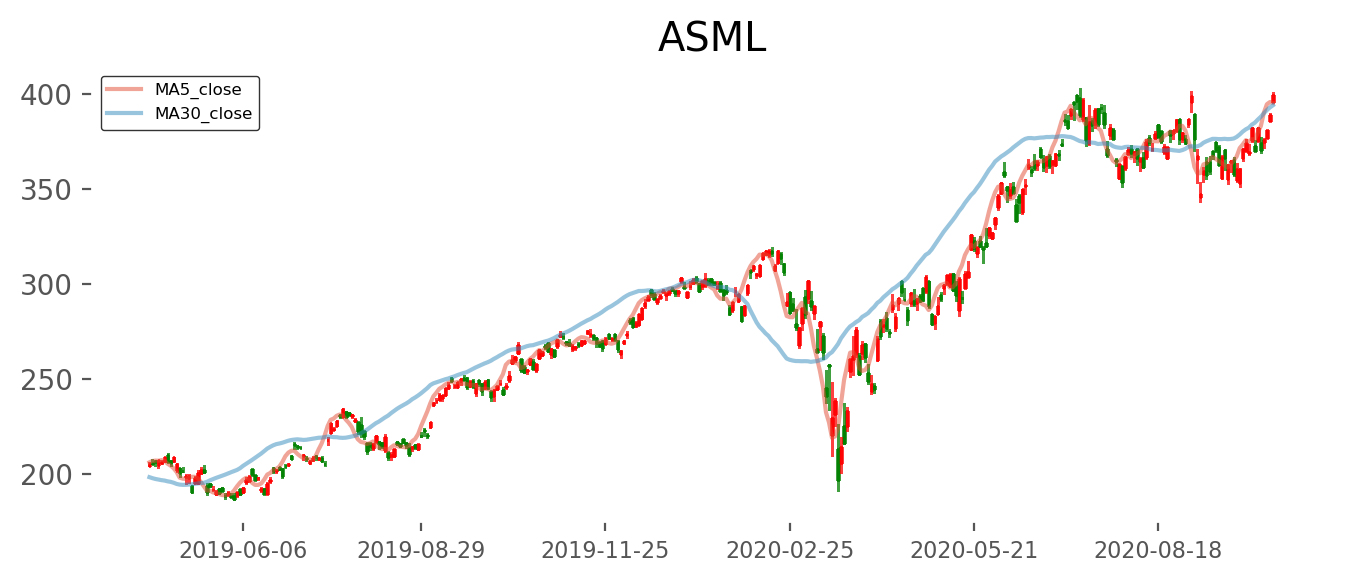

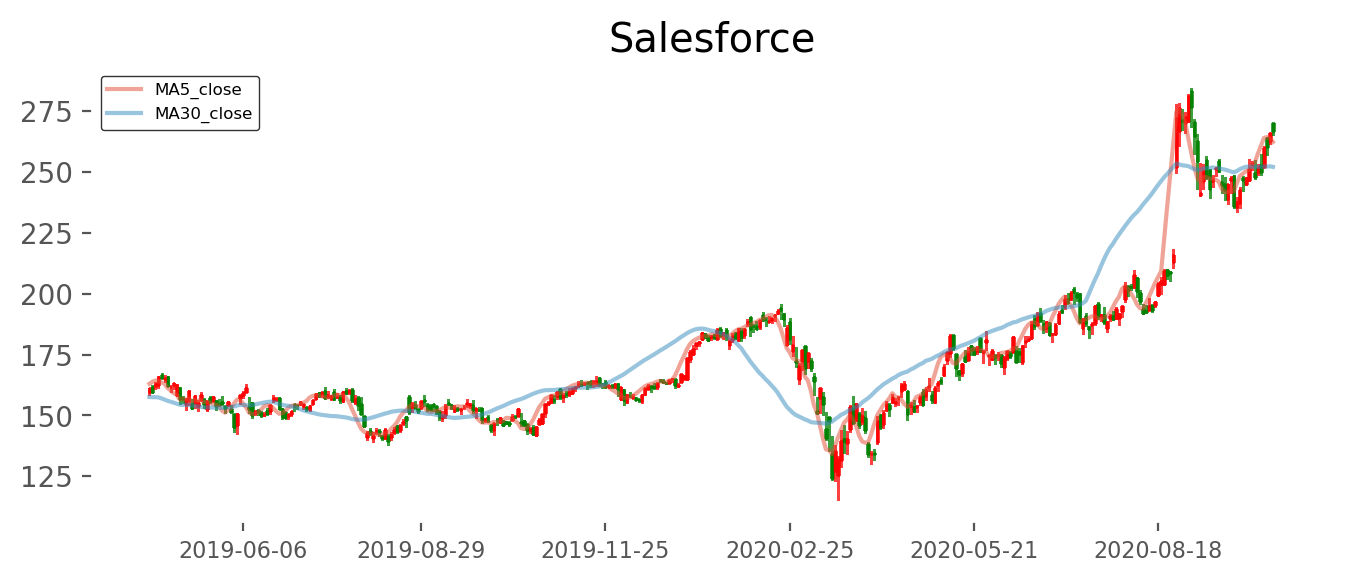

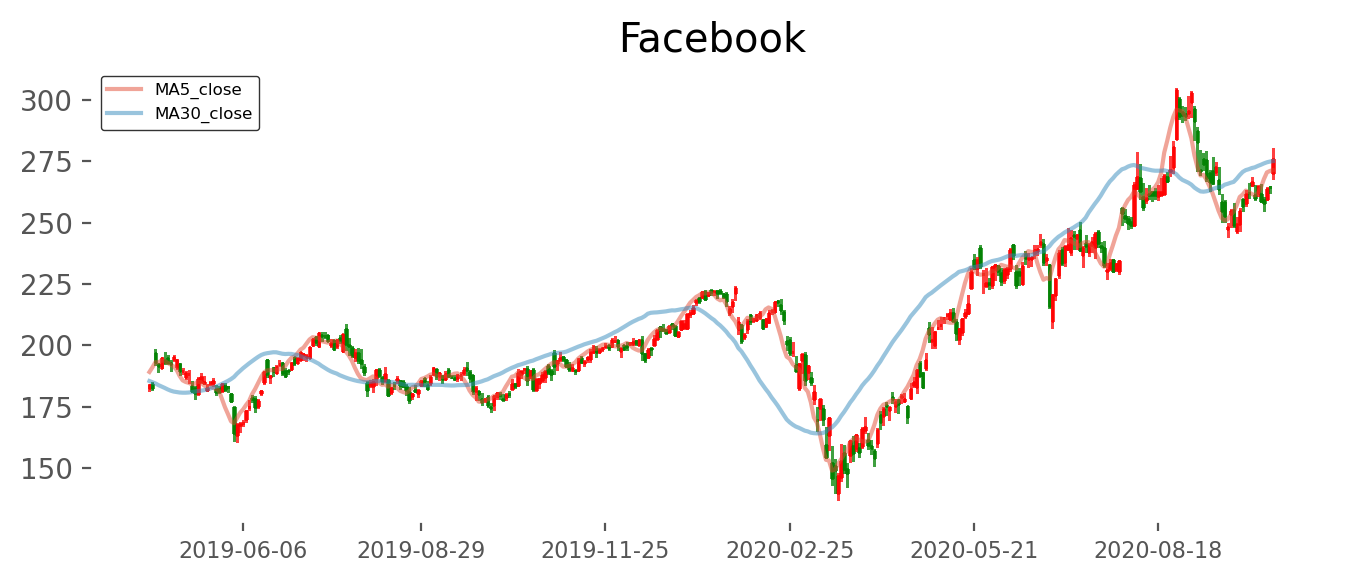

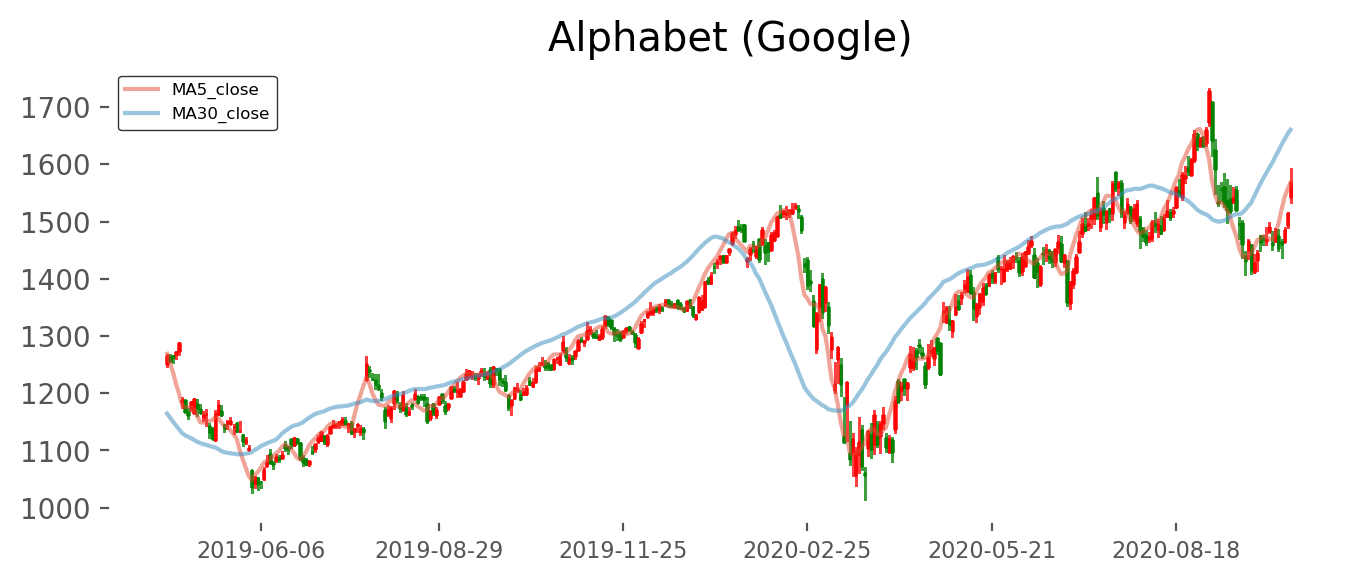

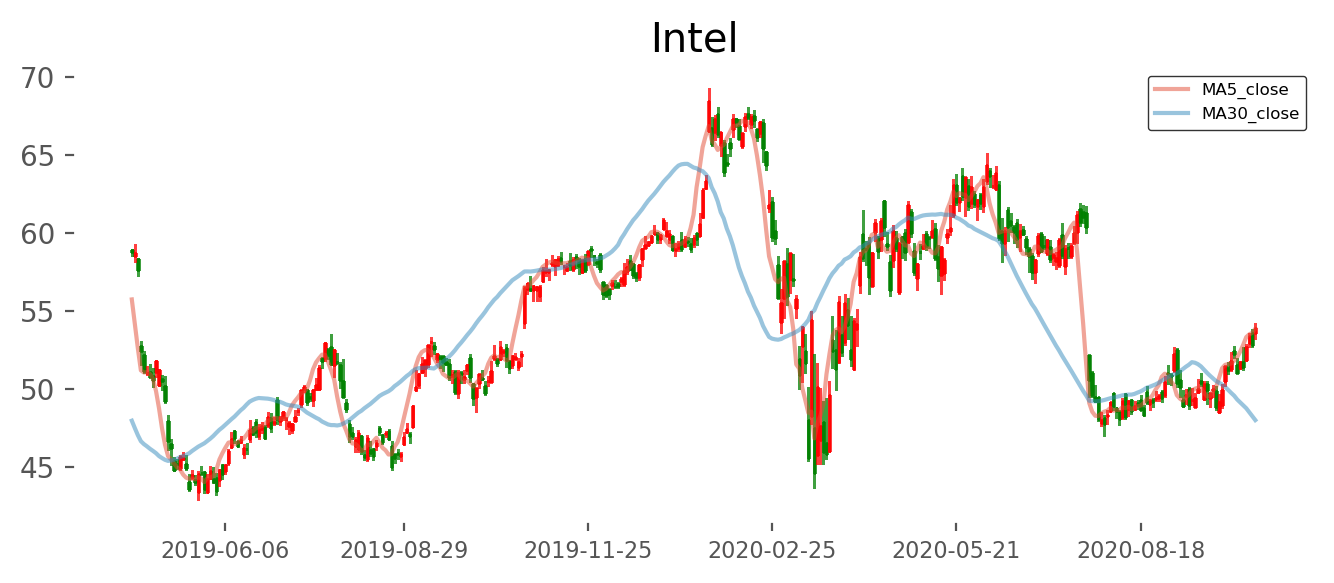

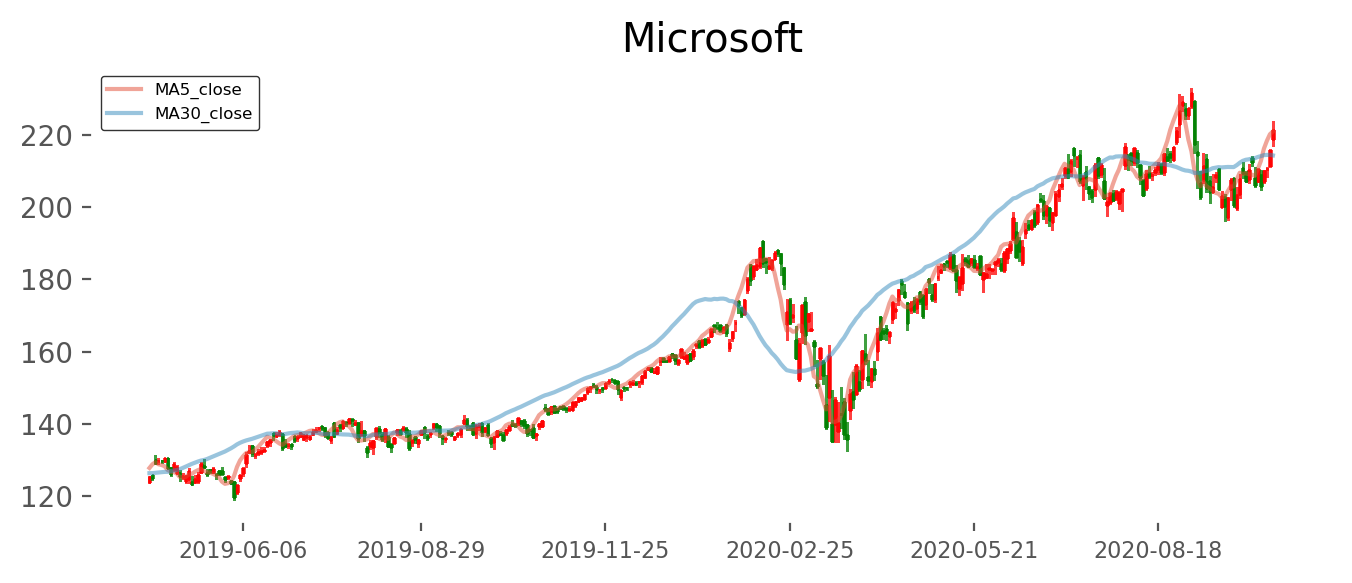

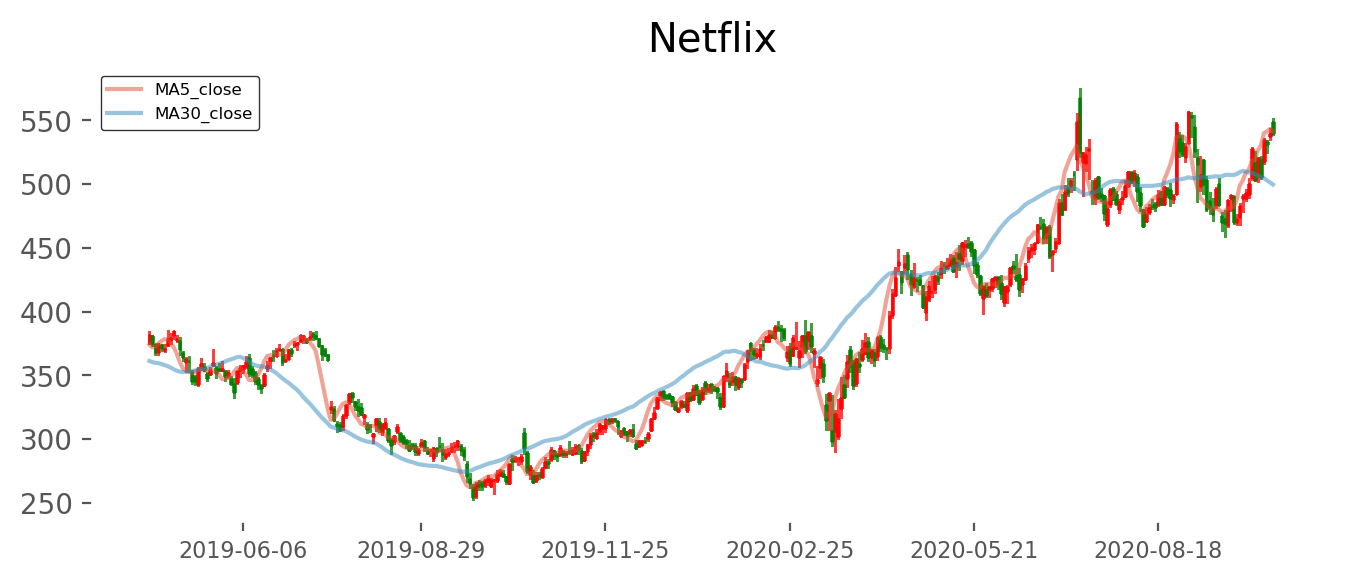

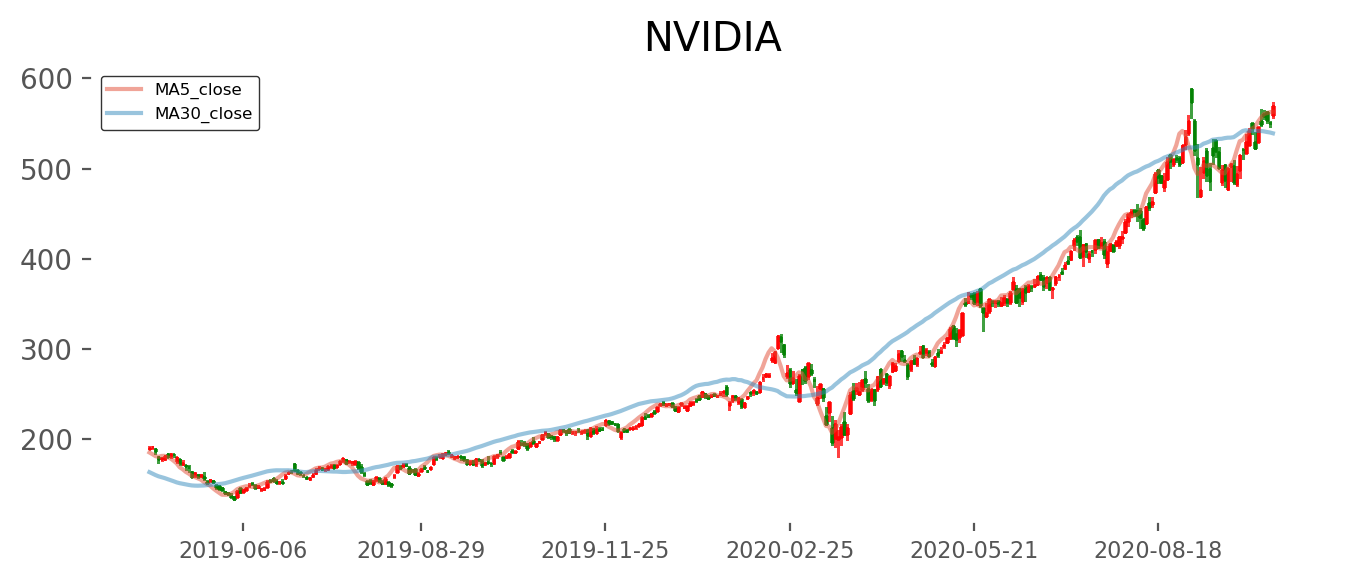

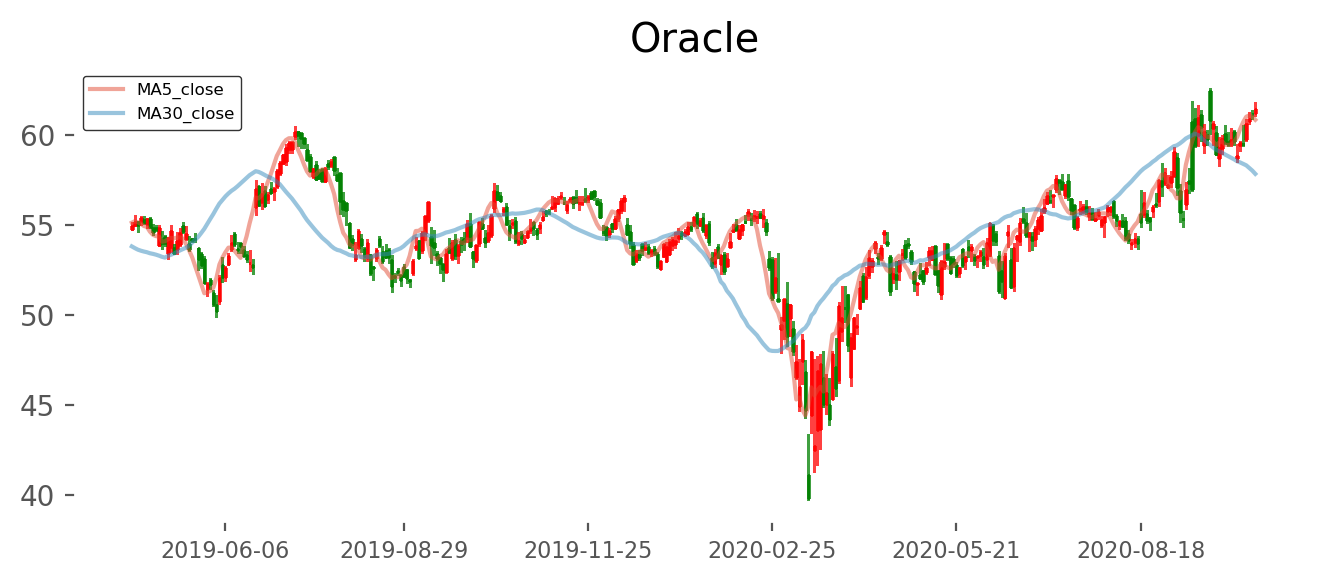

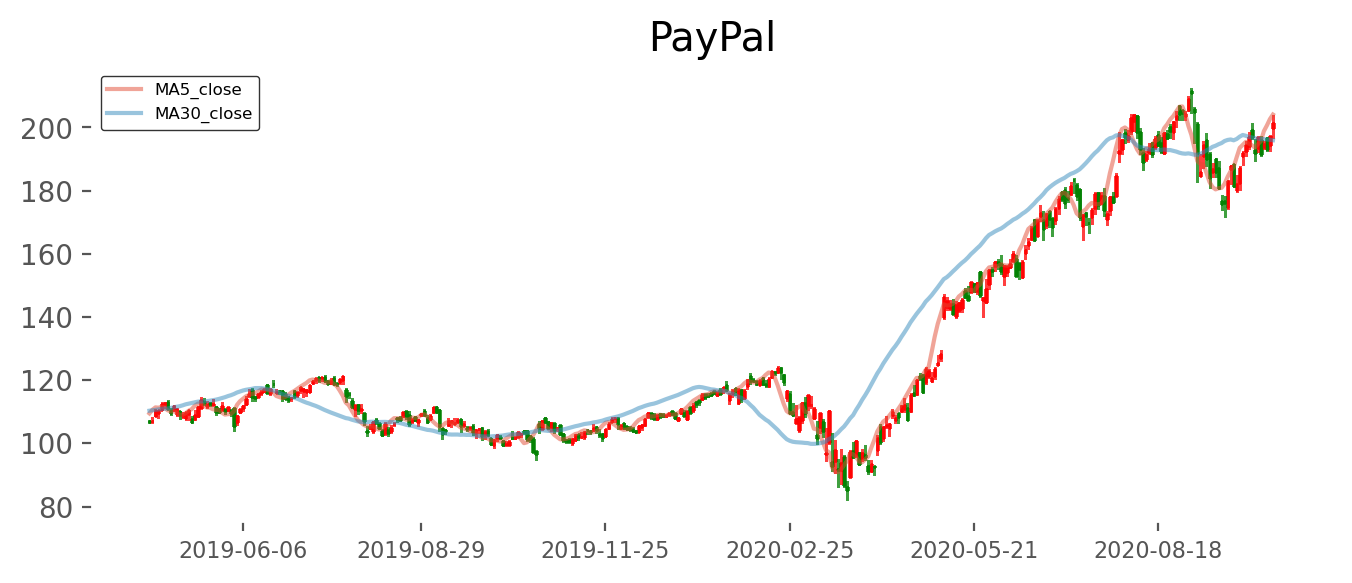

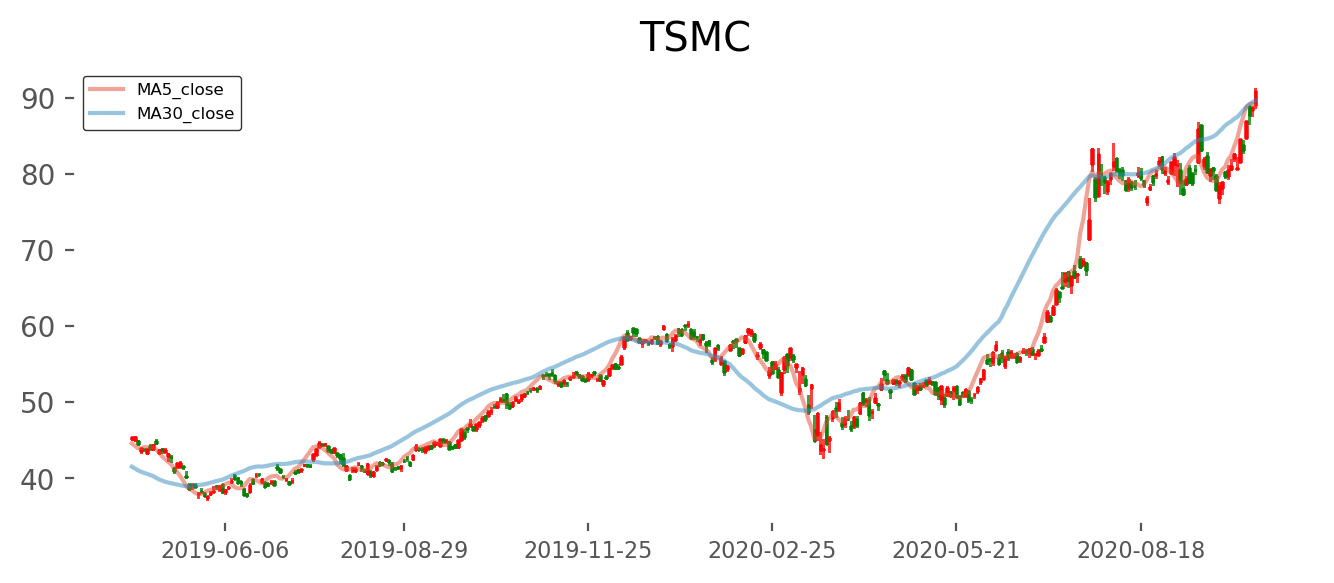

In [90]:
for i in range(len(stock_cluster4_symbols)):
    draw_kline(stock_cluster4_symbols[i],stock_cluster4_names[i])


In [ ]:
5日均线是短线股民不可或缺的一部分参考指标，因此其也叫攻击线，如果5日均线上涨角度陡峭有力，则说明价格短线爆发力强。

1. 30日均线为主力庄家的护盘线,当股价向上突破30日均线时,一般会有主力资金进场了,一旦进入上升,只要回调不跌破30日均线,就说明主力资金尚未出局,上升并未结束,主力资金往往会在股价下跌时守护30日均线.当然,根据主力的操盘风格和习惯不同,会选择不同的25-35之间不同的中期均线来守护.

2. 股价上升回落至30日均线的时间至少应在1周以上,有可能股价横向整理并不出现大幅回落,等待30日均线上行来靠近股价,也有可能会出现大幅回落主动靠近30日均线.因此,对于买入时机的把握,应有耐心,并关注30日均线的支撑.

3. 当股价回落至30日均线附近,买入操作后,股价不升反跌,并有效跌破30日均线,尤其是放量破位时,应该坚决止损离场,哪怕等待股价重新回到30日均线之上时才买入.

4. 如果股价是缩量跌破30日均线,而30日均线仍保持上行,随后股价很快又回到其上方,说明还有上升的动力,可以考虑买入或继续持股.

### 综合来看，选取paypal, nvdia, salesforce,microsoft, facebook 五只股票进行投资组合，预测其投资组合的回报率

In [94]:
select_stocks_symbol = ['PYPL','NVDA','CRM','MSFT','FB']

#### 1. 用LSTM预测股票价格

In [95]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

KeyboardInterrupt: 

#### Training data preparation

In [161]:
def data_train(stock_symbol):
    for file in glob.glob(os.getcwd()+'/train/'+"*.csv"): 
        if stock_symbol in file:
            stock = pd.read_csv(file)
            stock.drop(columns=['6. volume','7. dividend amount','8. split coefficient','stock symbol'],inplace = True)
            stock.sort_values(by=['date'],inplace=True)
            break    
    print(stock.head(10))

    training_set = stock.iloc[:, 1:12].values
        
    scaler = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = scaler.fit_transform(training_set)
    
    X_train = []
    y_train = []
    for i in range(60, len(stock.index)):
        X_train.append(training_set_scaled[i-60:i, :])
        y_train.append(training_set_scaled[i, :])

    X_train, y_train = np.array(X_train), np.array(y_train)      
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 11))
    
    return X_train,y_train,stock,scaler

In [ ]:
data_train('FB')

#### Test data

In [162]:
def test_data(train_data,scaler,stock_symbol):
    
    for file in glob.glob(os.getcwd()+'/test/'+"*.csv"): 
        if stock_symbol in file:
            stock = pd.read_csv(file)
            stock.drop(columns=['6. volume','7. dividend amount','8. split coefficient','stock symbol'],inplace = True)
            stock.sort_values(by=['date'],inplace=True)
            break
    
    real_stock_price = stock['4. close'].values
    
    dataset_total = pd.concat((train_data, stock), axis = 0)
    db_all = dataset_total.iloc[:, 1:12].values

    inputs = db_all[len(dataset_total) - len(stock) - 60:]
    inputs = inputs.reshape(-1,11)

    inputs = scaler.transform(inputs)
    X_test = []
    for i in range(60, 60+len(stock.index)):
        X_test.append(inputs[i-60:i, :])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 11))
    
    return X_test,real_stock_price,stock

#### 创建四个 LSTM 层 与一个全连接层的训练模型

In [163]:
def stock_model(X_train, y_train):
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 11)))
    
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))

    model.add(Dense(units = 11))
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    #model.fit(X_train, y_train, epochs = 100, batch_size = 64)
    model.fit(X_train, y_train, epochs = 50, batch_size = 32)
    
    return model

#### Prediction

In [164]:
def pred_price(X_train, y_train,train_data,scaler,symbol):
    regressor = stock_model(X_train, y_train)
    X_test,real_stock_price,test_dataset = test_data(train_data,scaler,symbol)
    predicted_stock_price = regressor.predict(X_test)

    predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
    print(predicted_stock_price[:,0])

    #return predicted_stock_price[:,0][-10:],real_stock_price[-10:],test_dataset
    return predicted_stock_price[:,0],real_stock_price,test_dataset


def plot_pred(predicted_stock_price,real_stock_price,symbol):
    plt.figure(figsize=(8, 3))
    plt.plot(real_stock_price, color = 'red', label = symbol+' Stock Price')
    plt.plot(predicted_stock_price, color = 'green', label = 'Predicted '+symbol+' Stock Price')
    plt.title(symbol+ ' Stock Price Prediction For 30 days')
    plt.xlabel('Day')
    plt.ylabel(symbol+' Stock Price')
    plt.legend()
    plt.show()    
    
    
def run_pred(stock_symbols):
    pred_price_df = pd.DataFrame()
    i = 0
    
    for symbol in stock_symbols:
        X_train, y_train,train_dataset,scaler = data_train(symbol)
        predicted_stock_price,real_stock_price,test_dataset = pred_price(X_train, y_train,train_dataset,scaler,symbol)
        plot_pred(predicted_stock_price,real_stock_price,symbol)
        pred_price_df[symbol] = predicted_stock_price
        
        if i == 0:
            test_date = test_dataset['date'].copy()
            #pd.to_datetime(test_date.sort_values(ascending=True,inplace=True))

            pred_price_df['date'] = test_date
            #print(pred_price_df)
            
            i += 1
    pred_price_df.set_index('date',inplace=True)
    return pred_price_df
    

Epoch 1/100
2/2 [==============================] - 4s 53ms/step - loss: 0.1827
Epoch 2/100
2/2 [==============================] - 0s 45ms/step - loss: 0.1020
Epoch 3/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0396
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0476
Epoch 5/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0261
Epoch 6/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0239
Epoch 7/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0299
Epoch 8/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0268
Epoch 9/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0186
Epoch 10/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0212
Epoch 11/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0199
Epoch 12/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0172
Epoch 13/100
2/2 [==============================]

[113.16652 111.2551  110.02456 109.85301 111.02326 113.68051 117.82674
 123.3403  129.98795 137.45618 145.3874  153.45128 161.38417 169.0182
 176.26495 183.0631  189.34897 195.08533 200.26797 204.90343 209.04286
 212.75497 216.09912 219.13123 221.90256 224.43538 226.73856 228.81157
 230.65524 232.27254]


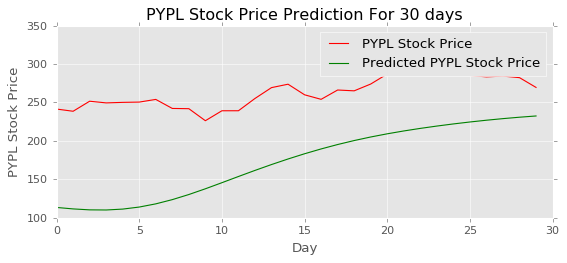

Epoch 1/100
2/2 [==============================] - 4s 50ms/step - loss: 0.3791
Epoch 2/100
2/2 [==============================] - 0s 47ms/step - loss: 0.2669
Epoch 3/100
2/2 [==============================] - 0s 44ms/step - loss: 0.1609
Epoch 4/100
2/2 [==============================] - 0s 49ms/step - loss: 0.0745
Epoch 5/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0698
Epoch 6/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0696
Epoch 7/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0511
Epoch 8/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0502
Epoch 9/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0472
Epoch 10/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0434
Epoch 11/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0396
Epoch 12/100
2/2 [==============================] - 0s 45ms/step - loss: 0.0329
Epoch 13/100
2/2 [==============================]

[282.90582 281.5188  282.05573 285.34793 291.90134 301.77    314.58594
 329.75922 346.504   363.94003 381.18008 397.57928 412.73282 426.52026
 439.04034 450.45663 460.8858  470.423   479.24896 487.429   495.12347
 502.4974  509.59204 516.4452  523.0834  529.4567  535.5273  541.16644
 546.2339  550.62103]


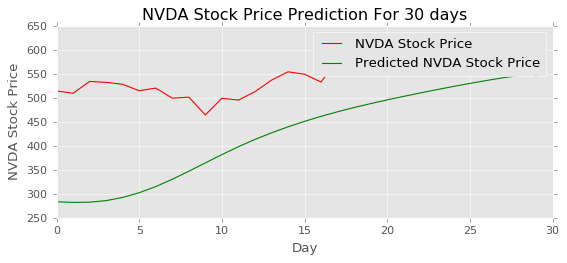

Epoch 1/100
2/2 [==============================] - 4s 53ms/step - loss: 0.2968
Epoch 2/100
2/2 [==============================] - 0s 46ms/step - loss: 0.1939
Epoch 3/100
2/2 [==============================] - 0s 47ms/step - loss: 0.1051
Epoch 4/100
2/2 [==============================] - 0s 49ms/step - loss: 0.0711
Epoch 5/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0649
Epoch 6/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0463
Epoch 7/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0534
Epoch 8/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0429
Epoch 9/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0382
Epoch 10/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0353
Epoch 11/100
2/2 [==============================] - 0s 57ms/step - loss: 0.0323
Epoch 12/100
2/2 [==============================] - 0s 56ms/step - loss: 0.0270
Epoch 13/100
2/2 [==============================]

[158.61531 157.61522 157.4284  158.33253 160.44254 163.6799  167.82867
 172.62163 177.74205 182.8795  187.76141 192.19286 196.02138 199.2065
 201.83296 204.03098 205.95528 207.83463 209.84929 212.04309 214.44916
 217.08116 219.8797  222.76244 225.62534 228.29268 230.64574 232.58452
 234.0896  235.2002 ]


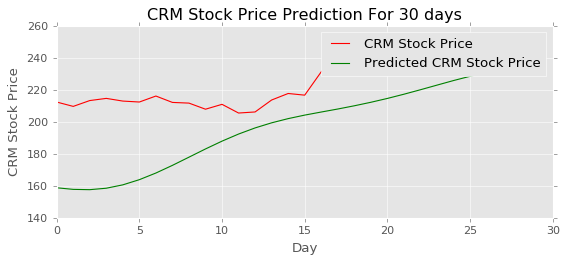

,PYPL,NVDA,CRM
date,,,
2021-03-19,113.166519,282.905823,158.615311
2021-03-18,111.255096,281.518799,157.615219
2021-03-17,110.024559,282.055725,157.428406
2021-03-16,109.853012,285.347931,158.332535
2021-03-15,111.023262,291.901337,160.442535
2021-03-12,113.680511,301.769989,163.679901
2021-03-11,117.826736,314.585938,167.828674
2021-03-10,123.340302,329.759216,172.621628
2021-03-09,129.987946,346.503998,177.742050


In [165]:
pred_price_df = run_pred(select_stocks_symbol)

pred_price_df

In [122]:
#select_stocks = stock_cluster[1]
#stock_names = select_stocks[1][1:6]
#stock_symbols = select_stocks[0][1:6]

#https://www.jianshu.com/p/4cc811402477

new_df = stocks[['date', 'stock symbol', '4. close']].copy()
#new_df['pct_change'] = new_df['pct_change (%)'].div(100).round(2)
new_df = new_df.pivot(index='date',columns='stock symbol')
col_name = [i[1] for i in new_df.columns]

new_df.columns = col_name
#print(new_df)


stock_return = new_df.pct_change().dropna()
#print(stock_return.head())


select_stock_df = stock_return[select_stocks_symbol].copy()
select_stock_df.dropna(inplace=True)
#select_stock_df.sort_index(ascending=True,inplace=False)
print(select_stock_df.head(5))

                PYPL      NVDA       CRM      MSFT        FB
date                                                        
2019-04-25  0.027980 -0.022284  0.022123  0.033117  0.058495
2019-04-26  0.003085 -0.047188  0.017598  0.005730 -0.009159
2019-04-29  0.017004  0.006963 -0.003615 -0.000924  0.017181
2019-04-30  0.002935  0.009312 -0.000060  0.006396 -0.007085
2019-05-01 -0.016228 -0.002928 -0.019353 -0.020827 -0.001913


### Portfolio Return

In [123]:


#print(select_stock)

def cal_weight(select_stock,select_stocks_symbol):
    
    number = 10000
    # 设置空的numpy数组，用于存储每次模拟得到的权重、收益率和标准差
    random_p = np.empty((number, 7))
    # 设置随机数种子，这里是为了结果可重复
    np.random.seed(100)
    
    cov_mat = select_stock.cov()
    cov_mat_annual = cov_mat * 252

    # 循环模拟10000次随机的投资组合
    for i in range(number):
        # 生成9个随机数，并归一化，得到一组随机的权重数据
        random5 = np.random.random(5)
        random_weight = random5 / np.sum(random5)

        # 计算年化平均收益率
        mean_return = select_stock.mul(random_weight, axis=1).sum(axis=1).mean()
        annual_return = (1 + mean_return)**252 - 1

        # 计算年化的标准差，也称为波动率
        random_volatility = np.sqrt(np.dot(random_weight.T,np.dot(cov_mat_annual, random_weight)))

        # 将上面生成的权重，和计算得到的收益率、标准差存入数组random_p中
        random_p[i][:5] = random_weight
        random_p[i][5] = annual_return
        random_p[i][6] = random_volatility

    # 将numpy数组转化成DataFrame数据框
    random_portfolios = pd.DataFrame(random_p)
    # 设置数据框RandomPortfolios每一列的名称
    random_portfolios.columns = [ticker + "_weight" for ticker in select_stocks_symbol]  + ['returns', 'volatility']
    
    plt.figure(1, facecolor='w', figsize=(10, 5))
    random_portfolios.plot('volatility', 'returns', kind='scatter')
    plt.show()
    
    
    min_index = random_portfolios.volatility.idxmin()

    GMV_weights = np.array(random_portfolios.iloc[min_index, 0:5])

    select_stock['portfolio_weight'] = select_stock.mul(GMV_weights, axis=1).sum(axis=1)

    return GMV_weights




<Figure size 720x360 with 0 Axes>

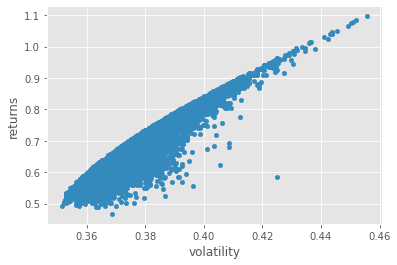

[0.01965079 0.00202012 0.07498191 0.44745744 0.45588975]


In [124]:
GMV_weights = cal_weight(select_stock_df,select_stocks_symbol)

print(GMV_weights)

# 预测未来的投资组合收益趋势

## 预测股票价格趋势

In [68]:
#X_train, y_train,train_data,scaler = data_train('AMZN')

In [73]:
def portfolio_pred(GMV_weights):
    port_df = pred_price_df.pct_change().dropna()

    # 计算加权的股票收益
    WeightedReturns = port_df.mul(GMV_weights, axis=1)

    # 计算投资组合的收益
    port_df['portfolio'] = WeightedReturns.sum(axis=1)

    return port_df

## 预测十天的这五只股票的投资组合收益率

In [74]:
portfolio_pred(GMV_weights)

,AMZN,CRM,FB,GOOG,MSFT,portfolio
date,,,,,,
2021-02-08,0.030931,0.009105,0.016258,0.018910,0.025141,0.020874
2021-02-09,0.026154,0.008342,0.013101,0.015993,0.021490,0.017722
2021-02-10,0.022136,0.007686,0.010555,0.013524,0.018397,0.015068
2021-02-11,0.018763,0.007095,0.008504,0.011436,0.015783,0.012835
2021-02-12,0.015910,0.006525,0.006851,0.009672,0.013570,0.010948
2021-02-16,0.013508,0.005978,0.005524,0.008181,0.011693,0.009353
2021-02-17,0.011490,0.005435,0.004453,0.006921,0.010109,0.008005
2021-02-18,0.009805,0.004922,0.003579,0.005851,0.008761,0.006860
2021-02-19,0.008413,0.004443,0.002868,0.004948,0.007617,0.005893
